# Custom Loss Tester

### Load libraries

In [1]:
import torch.nn.functional as F
import torch
from torch.autograd import Variable
from torch import autograd
import matplotlib.pyplot as plt
import math
import numpy as np
device = torch.device("cuda:0" if  torch.cuda.is_available() else "cpu")

### Add different loss function

In [2]:
# custom loss function used as followed: 
# bce_custom = bce_custom_loss.apply(Y, label_real)
# bce_custom.backward()

class bce_custom_loss(autograd.Function):
    @staticmethod
    def forward(ctx, x , y):
        loss = torch.mean(-y * torch.clamp(torch.log(x), min = -100) - (1.0-y) * torch.clamp(torch.log(1.0 - x),min = -100))
        ctx.save_for_backward(loss,x,y)
        return loss

    @staticmethod
    def backward(ctx, grad_output):
        result, x, y, = ctx.saved_tensors
        return torch.nan_to_num( torch.clamp(-( y/x - (1-y)/(1-x) ) ,min=-1.0000e+12,max=1.0000e+12 ) , nan=0.0)  , None
    
def bce_w_logit(input, target, weight=None, average=True):
   
    if weight is not None and weight.dim() != target.dim() and target.dim() != 1:
        weight = weight.view(1, target.size(1)).expand_as(target)

    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()

    if weight is not None:
        loss = loss * weight

    if average:
        return loss.mean()
    else:
        return loss.sum()

def my_bce_with_logits_loss(x, y):
    loss = -1.0 * (y * F.logsigmoid(x) + (1 - y) * torch.log(1 - torch.sigmoid(x)))
    loss = loss.mean()
    return loss

def my_bce_with_logits_loss_stable(x, y):
    max_val = (-x).clamp_min_(0)
    loss = (1 - y) * x + max_val + torch.log(torch.exp(-max_val) + torch.exp(-x - max_val))
    loss = loss.mean()
    return loss

### Load test data

In [3]:
# manually loaded 10 samples from test data
device = torch.device("cuda:0" if  torch.cuda.is_available() else "cpu")
real_pred= torch.tensor([0.8114, 0.2695, 0.8771, 0.4360, 0.7581, 0.8822, 0.6321, 0.5566, 0.6454,
        0.4139]).to(device)
fake_pred=torch.tensor([0.0541, 0.5377, 0.8052, 0.8737, 0.3856, 0.2496, 0.2741, 0.3890, 0.1179,
        0.7338]).to(device)
label_real= torch.tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]).to(device)
label_fake= torch.tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]).to(device)

In [4]:
print("------Generator Loss------------")
print("F.binary_cross_entropy:", F.binary_cross_entropy(fake_pred, label_real))
print("bce_custom_loss:", bce_custom_loss.apply(fake_pred, label_real))
print("bce_w_logits:", bce_w_logit(fake_pred, label_real))
print("bce_with_logits:", my_bce_with_logits_loss(fake_pred, label_real))
print("bce_with_logits_stable:", my_bce_with_logits_loss_stable(fake_pred, label_real))
print("------Discriminator Loss--------")
print("F.binary_cross_entropy:",0.5 * (F.binary_cross_entropy(label_real, real_pred) + F.binary_cross_entropy(label_fake, fake_pred)))
print("bce_custom_loss:", 0.5 * (bce_custom_loss.apply(label_real, real_pred) + bce_custom_loss.apply(label_fake, fake_pred)))
print("bce_logit:", 0.5 * (bce_w_logit(label_real, real_pred) +  bce_w_logit(label_fake, fake_pred)))
print("bce_logit:", 0.5 * (my_bce_with_logits_loss_stable(label_real, real_pred) +  my_bce_with_logits_loss_stable(label_fake, fake_pred)))


------Generator Loss------------
F.binary_cross_entropy: tensor(1.0916)
bce_custom_loss: tensor(1.0916)
bce_w_logits: tensor(0.5051)
bce_with_logits: tensor(0.5051)
bce_with_logits_stable: tensor(0.5051)
------Discriminator Loss--------
F.binary_cross_entropy: tensor(40.6920)
bce_custom_loss: tensor(40.6920)
bce_logit: tensor(0.6891)
bce_logit: tensor(0.6891)


In [5]:
losses=[3.720076e-45]
for i in range(1,45):
    losses.append(losses[i-1]*10)
    
np.log(losses)

array([-102.30258509,  -99.99999999,  -97.6974149 ,  -95.39482981,
        -93.09224471,  -90.78965962,  -88.48707453,  -86.18448944,
        -83.88190434,  -81.57931925,  -79.27673416,  -76.97414906,
        -74.67156397,  -72.36897888,  -70.06639378,  -67.76380869,
        -65.4612236 ,  -63.15863851,  -60.85605341,  -58.55346832,
        -56.25088323,  -53.94829813,  -51.64571304,  -49.34312795,
        -47.04054285,  -44.73795776,  -42.43537267,  -40.13278758,
        -37.83020248,  -35.52761739,  -33.2250323 ,  -30.9224472 ,
        -28.61986211,  -26.31727702,  -24.01469192,  -21.71210683,
        -19.40952174,  -17.10693665,  -14.80435155,  -12.50176646,
        -10.19918137,   -7.89659627,   -5.59401118,   -3.29142609,
         -0.98884099])

In [6]:
label_real = torch.tensor([1.0]).to(device)
grad = []
grad_custom = []
grad_custom_w_logit = []
grad_custom_w_logit2 = []
for val in losses:
    X = Variable(torch.tensor([val]).to(device), requires_grad=True)
    Y = Variable(torch.tensor([val]).to(device), requires_grad=True)
    Z = Variable(torch.tensor([val]).to(device), requires_grad=True)
    XY = Variable(torch.tensor([val]).to(device), requires_grad=True)
    # binrary cross entropy pytorch  
    F_bce_loss = F.binary_cross_entropy(X, label_real)
    F_bce_loss.backward()
    grad.append(X.grad)
    
    # custom loss
    bce_custom=bce_custom_loss.apply(Y, label_real)
    bce_custom.backward()
    grad_custom.append(Y.grad)
    
    bce_custom_w_logit = bce_w_logit(Z, label_real)
    bce_custom_w_logit.backward()
    grad_custom_w_logit.append(Z.grad)
    
    bce_custom_w_logit2 = my_bce_with_logits_loss(XY, label_real)
    bce_custom_w_logit2.backward()
    grad_custom_w_logit2.append(XY.grad)


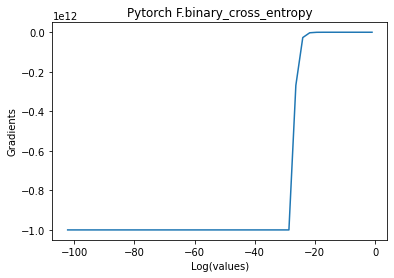

In [11]:
plt.xlabel('Log(values)')
plt.ylabel('Gradients')
plt.title('Pytorch F.binary_cross_entropy')
plt.plot(list(torch.log(torch.tensor(losses))),list(grad))

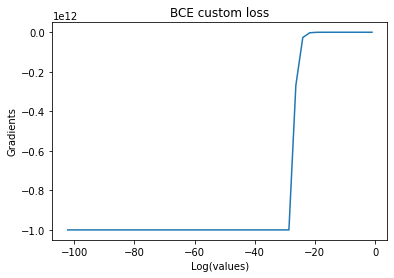

In [12]:
plt.xlabel('Log(values)')
plt.ylabel('Gradients')
plt.title('BCE custom loss')
plt.plot(list(torch.log(torch.tensor(losses))),list(grad_custom))

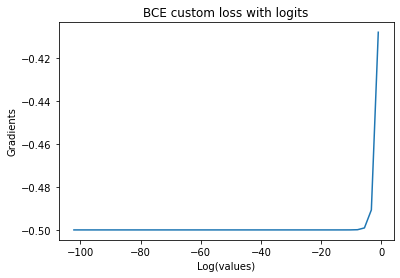

In [13]:
plt.xlabel('Log(values)')
plt.ylabel('Gradients')
plt.title('BCE custom loss with logits 1')
plt.plot(list(torch.log(torch.tensor(losses))),list(grad_custom_w_logit))

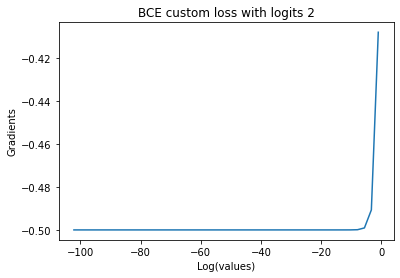

In [14]:
plt.xlabel('Log(values)')
plt.ylabel('Gradients')
plt.title('BCE custom loss with logits 2')
plt.plot(list(torch.log(torch.tensor(losses))),list(grad_custom_w_logit2))

In [ ]:
grad_costum

In [ ]:
grad

In [ ]:
grad_custom_w_logit